<a href="https://colab.research.google.com/github/An210/ML/blob/main/LSTM_Crypto%20Grid%20Search%20%26%20Model%20Selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
# Install necessary packages
!pip install cryptocompare seaborn scikit-learn scikeras

# Import necessary libraries
import seaborn as sns
import requests
import pandas as pd
from datetime import datetime, timedelta
import cryptocompare
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout, Input
import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasRegressor

In [15]:


def get_historical_price_data(period=360):
    # Get the current timestamp
    end_time = datetime.now()

    # Calculate the start time (30 days ago)
    start_time = end_time - timedelta(days=period)

    # Convert timestamps to Unix timestamps
    end_timestamp = int(end_time.timestamp())
    start_timestamp = int(start_time.timestamp())

    # Get historical price data
    price_data = cryptocompare.get_historical_price_day(
        'ETH', 'USD', limit=period, toTs=end_timestamp, exchange='CCCAGG'
    )

    # Create a Pandas DataFrame
    df = pd.DataFrame(price_data)

    # Convert 'time' column to datetime objects
    df['time'] = pd.to_datetime(df['time'], unit='s')

    # Rename columns to match your desired format
    df = df.rename(
        columns={
            'time': 'Timestamp',
            'high': 'High',
            'low': 'Low',
            'open': 'Open',
            'volumefrom': 'VolumeFrom',
            'volumeto': 'VolumeTo',
            'close': 'Close',
        }
    )

    return df

# Get historical price data
historical_data = get_historical_price_data()
historical_data = historical_data.drop(['conversionType', 'conversionSymbol'], axis=1)

# Print the DataFrame
print(historical_data.sort_values(by='Timestamp', ascending=False))

     Timestamp     High      Low     Open  VolumeFrom      VolumeTo    Close
360 2024-11-18  3124.48  3069.70  3076.78    86985.90  2.696827e+08  3116.59
359 2024-11-17  3161.64  3035.43  3134.46   883275.45  2.731030e+09  3076.78
358 2024-11-16  3220.45  3073.05  3091.03   711991.72  2.242190e+09  3134.46
357 2024-11-15  3131.21  3014.42  3059.11  1010306.63  3.095290e+09  3091.03
356 2024-11-14  3242.46  3029.87  3191.32  1094612.33  3.442350e+09  3059.11
..         ...      ...      ...      ...         ...           ...      ...
4   2023-11-28  2075.82  1995.65  2027.67   244541.64  4.991779e+08  2049.10
3   2023-11-27  2071.85  1986.06  2063.01   266169.84  5.387659e+08  2027.67
2   2023-11-26  2095.12  2037.74  2084.06   129845.35  2.688176e+08  2063.01
1   2023-11-25  2091.51  2067.12  2082.24    82529.48  1.718206e+08  2084.06
0   2023-11-24  2133.82  2059.80  2062.63   274783.65  5.768434e+08  2082.24

[361 rows x 7 columns]


In [16]:
X = historical_data.copy()
y = X.pop("Close")
X['Timestamp'] = pd.to_datetime(X['Timestamp']).astype('int64') // 10**9

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# Verify integer types and correct them if needed
X = X.apply(lambda x: pd.to_numeric(x, downcast='integer'))

# Check for discrete features
discrete_features = X.dtypes == 'int'

# Define function for MI scores
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

# Calculate MI scores
mi_scores = make_mi_scores(X, y, discrete_features)
print("\nSelected MI Scores:\n", mi_scores[::1])





Selected MI Scores:
 High          2.287201
Low           2.220157
Open          1.704153
Timestamp     1.538423
VolumeFrom    0.095186
VolumeTo      0.087045
Name: MI Scores, dtype: float64


/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:378: RuntimeWarning: invalid value encountered in cast
  new_result = trans(result).astype(dtype)


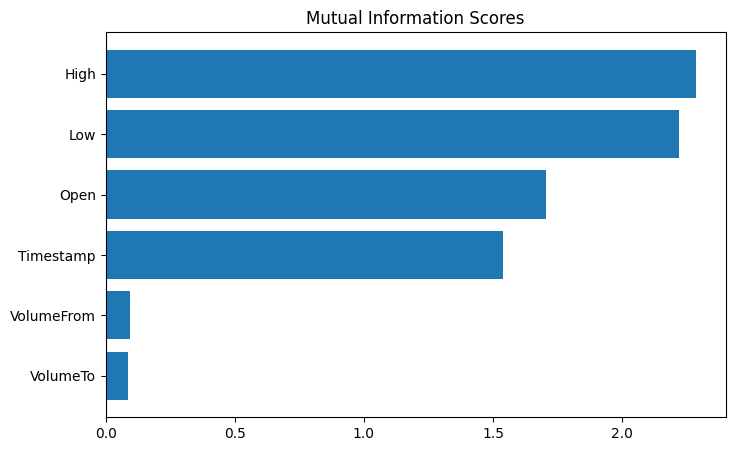

In [17]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

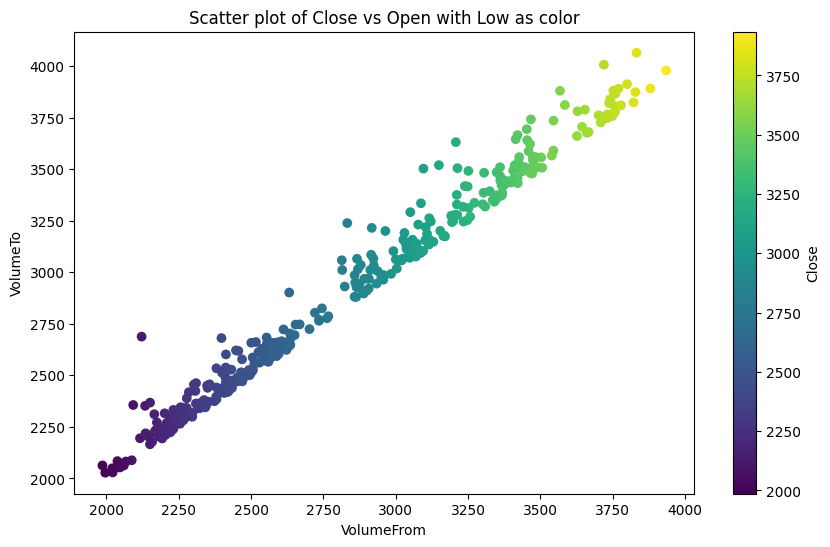

In [18]:

plt.figure(figsize=(10, 6))
scatter = plt.scatter(historical_data["Low"], historical_data["Open"], c=historical_data["Low"], cmap="viridis")
plt.colorbar(scatter, label="Close")
plt.xlabel("VolumeFrom")
plt.ylabel("VolumeTo")
plt.title("Scatter plot of Close vs Open with Low as color")
plt.show()

In [19]:


scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(historical_data[['High', 'Low', 'Open', 'VolumeFrom', 'VolumeTo', 'Close']])

# Create sequences for LSTM
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length + 1])
    return np.array(sequences)

seq_length = 10  # You can adjust this based on your data
sequences = create_sequences(scaled_data, seq_length)

# Split into features (X) and target (y)
X = sequences[:, :-1]
y = sequences[:, -1, -1]  # We are predicting the 'Close' price
# Split into training and validation sets
split = int(0.8 * len(X))
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]


In [ ]:
def create_model(lstm_units=100, dropout_rate=0.3, learning_rate=0.0005):
    model = Sequential()
    model.add(Input(shape=(seq_length, X_train.shape[2])))  # Input layer shape
    model.add(Bidirectional(LSTM(lstm_units, return_sequences=True)))
    model.add(Dropout(dropout_rate))
    model.add(Bidirectional(LSTM(lstm_units // 2))) # Input layer shape
    model.add(Dropout(dropout_rate))
    model.add(Dense(25))
    model.add(Dense(1))  # Output layer for regression
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Create a KerasRegressor for the LSTM model
lstm_model = KerasRegressor(
    model=create_model,
    lstm_units=100,
    dropout_rate=0.3,
    learning_rate=0.0005,
    verbose=0
)

models = {
    'LSTM': lstm_model,  # Add the LSTM model to the dictionary
    'RandomForestRegressor': RandomForestRegressor(random_state=0)  # Add a suitable regression model
}


model_grid_params = {
     'LSTM': {
        'model__lstm_units': [50, 100, 150],  # Notice 'model__' prefix
        'model__dropout_rate': [0.2, 0.3, 0.4],  # Notice 'model__' prefix
        'model__learning_rate': [0.001, 0.0005, 0.0001],  # Notice 'model__' prefix
        'batch_size': [16, 32, 64],
        'epochs': [2, 2, 2]
    },
    'RandomForestRegressor': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 2, 2]
    }
}


# Create TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

best_models = {}  # Store the best models

for model_name, model in models.items():
    print(f"Performing Grid Search for {model_name}...")

    # Get the hyperparameter grid for the current model
    param_grid = model_grid_params.get(model_name, {})

    # Create GridSearchCV object
    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error')

    # Reshape X data if necessary (for LSTM and other models that require 3D input)
    if model_name in ['LSTM']:
        # Assuming X is already in the correct shape for LSTM: (samples, timesteps, features)
        X_reshaped = X
    else:
        X_reshaped = X.reshape(X.shape[0], -1) # Reshape for other models if needed

    # Fit the grid search to your data
    grid_result = grid.fit(X_reshaped, y)  # Assuming y is your target variable

    # Print the best parameters and score
    print(f"Best parameters for {model_name}: {grid_result.best_params_}")
    print(f"Best score for {model_name}: {grid_result.best_score_}")

    # Store the best model
    best_models[model_name] = grid_result.best_estimator_

Performing Grid Search for LSTM...


# Testing model for predicting future values






In [ ]:
# Number of days to predict ahead
num_days_ahead = 20

# Get the last 'seq_length' data points from historical_data
current_sequence = scaled_data[-seq_length:]
predictions = []
timestamps = []
trade_timestamps = []  # Initialize trade_timestamps as a list

# Loop to predict for the next 'num_days_ahead' days
for i in range(num_days_ahead):
    # Reshape the current sequence to match the model's input shape
    current_sequence = current_sequence.reshape((1, seq_length, scaled_data.shape[1]))

    # Make prediction for the next day
    prediction = model.predict(current_sequence)

    # Inverse transform prediction to get actual price
    prediction = scaler.inverse_transform(np.concatenate((np.zeros((prediction.shape[0], scaled_data.shape[1] - 1)), prediction), axis=1))[:, -1]

    # Reshape the prediction to match the dimensions of current_sequence
    prediction_reshaped = np.repeat(prediction[:, np.newaxis], scaled_data.shape[1], axis=1)
    prediction_reshaped = prediction_reshaped.reshape(1, 1, scaled_data.shape[1])

    #Create a temporary DataFrame for scaling
    temp_df = pd.DataFrame(prediction_reshaped.reshape(1, -1), columns=['High', 'Low', 'Open', 'VolumeFrom', 'VolumeTo', 'Close'])

    #Scale using the temporary DataFrame
    prediction_scaled = scaler.transform(temp_df).reshape(1, 1, scaled_data.shape[1])

    # Get the timestamp for the prediction
    timestamp = historical_data['Timestamp'].iloc[-1] + pd.Timedelta(days=i + 1)  # Add i+1 days to the last timestamp

    # Print prediction with timestamp
    print(f"Predicted Ethereum price for {timestamp}: {prediction[0]}")
    predictions.append(prediction[0])
    timestamps.append(timestamp)
    # Update the current sequence for the next prediction
    current_sequence = np.append(current_sequence[:, 1:, :], prediction_scaled, axis=1)  # Append the prediction to the sequence and remove the first element

plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(historical_data['Timestamp']), historical_data['Close'], label='Original Close Price', marker='o')
plt.plot(timestamps, predictions, label='Predicted Close Price', marker='x', linestyle='--')
plt.xlabel('Timestamp')
plt.ylabel('Close Price')
plt.title('Ethereum Close Price Prediction')
plt.legend()
plt.grid(True)
plt.show()

# Run model's back testing

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error


backtest_start_date = '2024-01-01'  # Adjust this to your desired start date
backtest_end_date = '2024-11-15'  # Adjust this to your desired end date

# Filter historical data for the backtesting period
backtest_data = historical_data[(historical_data['Timestamp'] >= backtest_start_date) & (historical_data['Timestamp'] <= backtest_end_date)]

# Prepare backtesting data
scaled_backtest_data = scaler.transform(backtest_data[['High', 'Low', 'Open', 'VolumeFrom', 'VolumeTo', 'Close']])
backtest_sequences = create_sequences(scaled_backtest_data, seq_length)
X_backtest = backtest_sequences[:, :-1]
y_backtest = backtest_sequences[:, -1, -1]  # We are predicting the 'Close' price

# Make predictions on the backtesting data
backtest_predictions = model.predict(X_backtest)

# Inverse transform the predictions to get the actual close prices
backtest_predictions = scaler.inverse_transform(np.concatenate((np.zeros((backtest_predictions.shape[0], X_backtest.shape[2] - 1)), backtest_predictions), axis=1))[:, -1]

# Evaluate backtesting performance
rmse = np.sqrt(mean_squared_error(backtest_data['Close'].iloc[seq_length:], backtest_predictions))
r2 = r2_score(backtest_data['Close'].iloc[seq_length:], backtest_predictions)
mape = mean_absolute_percentage_error(backtest_data['Close'].iloc[seq_length:], backtest_predictions)

print(f'Backtesting RMSE: {rmse}')
print(f'Backtesting R-squared: {r2}')
print(f'Backtesting MAPE: {mape}')

# Plotting the backtesting results
plt.figure(figsize=(12, 6))
plt.plot(backtest_data['Timestamp'].iloc[seq_length:], backtest_data['Close'].iloc[seq_length:], label='Actual', color='blue')
plt.plot(backtest_data['Timestamp'].iloc[seq_length:], backtest_predictions, label='Predicted', color='red')
plt.xlabel('Timestamp')
plt.ylabel('Ethereum Price')
plt.title('Ethereum Price Backtesting')
plt.legend()
plt.grid(True)
plt.show()

# Plot cumulative profit/loss and trading submissions

In [ ]:


def run_backtest(backtest_predictions, backtest_data, seq_length, initial_budget=10000,
                 position_size=0.2, min_trade_amount=10):
    """
    Run backtest with support for partial units trading

    Parameters:
    -----------
    backtest_predictions : array-like
        Model predictions for buy/sell signals
    backtest_data : pandas.DataFrame
        Historical price data with 'Close' column
    seq_length : int
        Sequence length used in the model
    initial_budget : float
        Starting budget for trading
    position_size : float
        Percentage of budget to use per trade (0.0 to 1.0)
    min_trade_amount : float
        Minimum amount in currency units for a trade

    Returns:
    --------
    dict
        Dictionary containing backtest results and metrics
    """
    profit_loss_backtest = []
    trades = []
    current_budget = initial_budget
    current_holdings = 0  # Amount of coins/shares held

    # Trading metrics
    num_trades = 0
    winning_trades = 0
    losing_trades = 0

    # Ensure proper length for backtesting
    test_length = min(len(backtest_predictions), len(backtest_data))

    for i in range(1, test_length):
        current_price = backtest_data['Close'].iloc[i - 1 + seq_length]
        next_price = backtest_data['Close'].iloc[i + seq_length]

        # Calculate trade size based on position sizing
        max_trade_amount = current_budget * position_size

        if backtest_predictions[i - 1] > current_price:  # Buy signal
            if current_budget >= min_trade_amount:
                # Calculate amount to buy
                trade_amount = min(max_trade_amount, current_budget)
                coins_to_buy = trade_amount / current_price

                # Execute buy
                current_holdings += coins_to_buy
                current_budget -= trade_amount

                trades.append({
                    'type': 'buy',
                    'price': current_price,
                    'amount': coins_to_buy,
                    'value': trade_amount,
                    'timestamp': backtest_data['Timestamp'].iloc[i - 1 + seq_length]
                })

                profit_loss_backtest.append(0)  # No immediate P/L on buy
                num_trades += 1
            else:
                profit_loss_backtest.append(0)

        else:  # Sell signal
            if current_holdings > 0:
                # Calculate sell value
                sell_value = current_holdings * current_price
                profit_loss = current_holdings * (current_price - trades[-1]['price'])

                # Track trade outcome
                if profit_loss > 0:
                    winning_trades += 1
                elif profit_loss < 0:
                    losing_trades += 1

                # Execute sell
                current_budget += sell_value
                profit_loss_backtest.append(profit_loss)

                trades.append({
                    'type': 'sell',
                    'price': current_price,
                    'amount': current_holdings,
                    'value': sell_value,
                    'profit_loss': profit_loss,
                    'timestamp': backtest_data['Timestamp'].iloc[i - 1 + seq_length]
                })

                current_holdings = 0
                num_trades += 1
            else:
                profit_loss_backtest.append(0)

    # Calculate final metrics
    cumulative_profit_loss = sum(profit_loss_backtest)
    win_rate = winning_trades / num_trades if num_trades > 0 else 0

    # Calculate current portfolio value (cash + holdings)
    final_holding_value = current_holdings * backtest_data['Close'].iloc[-1]
    total_portfolio_value = current_budget + final_holding_value

    # Calculate return metrics
    total_return = (total_portfolio_value - initial_budget) / initial_budget * 100

    return {
        'trades': trades,
        'profit_loss_history': profit_loss_backtest,
        'cumulative_profit_loss': cumulative_profit_loss,
        'final_budget': current_budget,
        'final_holdings': current_holdings,
        'final_portfolio_value': total_portfolio_value,
        'total_return_pct': total_return,
        'num_trades': num_trades,
        'win_rate': win_rate,
        'metrics': {
            'winning_trades': winning_trades,
            'losing_trades': losing_trades,
            'win_rate': win_rate
        }
    }

def plot_backtest_results(backtest_results, backtest_data):
    """
    Plot backtest results including portfolio value and trade points
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

    # Plot 1: Cumulative Profit/Loss
    cumulative_pl = np.cumsum(backtest_results['profit_loss_history'])
    # Fix: Generate trade_timestamps based on the length of cumulative_pl
    # to ensure they have the same dimension.
    trade_timestamps = backtest_data['Timestamp'].iloc[seq_length:seq_length + len(cumulative_pl)].values

    ax1.plot(trade_timestamps, cumulative_pl)
    ax1.set_title('Cumulative Profit/Loss Over Time')
    ax1.set_xlabel('Date')  # Changed x-axis label for clarity
    ax1.set_ylabel('Profit/Loss')
    ax1.grid(True)

     # Plot 2: Price with Buy/Sell points
    ax2.plot(backtest_data['Timestamp'].iloc[seq_length:], backtest_data['Close'].iloc[seq_length:], label='Price', alpha=0.7)

    # Plot buy points
    buy_trades = [t for t in backtest_results['trades'] if t['type'] == 'buy']
    if buy_trades:
        buy_times = [t['timestamp'] for t in buy_trades]
        buy_prices = [t['price'] for t in buy_trades]
        ax2.scatter(buy_times, buy_prices, color='green', marker='^', label='Buy')

    # Plot sell points
    sell_trades = [t for t in backtest_results['trades'] if t['type'] == 'sell']
    if sell_trades:
        sell_times = [t['timestamp'] for t in sell_trades]
        sell_prices = [t['price'] for t in sell_trades]
        ax2.scatter(sell_times, sell_prices, color='red', marker='v', label='Sell')

    ax2.set_title('Price Chart with Trade Points')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Price')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# Example usage:

# Run backtest
backtest_results = run_backtest(
    backtest_predictions,
    backtest_data,
    seq_length=seq_length,
    initial_budget=10000,
    position_size=1,  # Use 20% of budget per trade
    min_trade_amount=10
)

# Print results
print(f"Final Portfolio Value: ${backtest_results['final_portfolio_value']:.2f}")
print(f"Total Return: {backtest_results['total_return_pct']:.2f}%")
print(f"Number of Trades: {backtest_results['num_trades']}")
print(f"Win Rate: {backtest_results['win_rate']*100:.2f}%")

# Plot results
plot_backtest_results(backtest_results, backtest_data)


In [ ]:
print(backtest_data.index[i - 1 + seq_length])